# Exploratory Data Analysis

## Check Version
Checking the version of which Spark and Python installed is important as it changes very quickly and drastically. Reading the wrong documentation can cause lots of lost time and unnecessary frustration!

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
# Return spark version
print(spark.version)

# Return python version
import sys
print(sys.version_info)

## Load in the data
Reading in data is the first step to using PySpark for data science! Let's leverage the new industry standard of parquet files!

In [ ]:
import pandas as pd
# Read the file into a dataframe
df = pd.read_csv('2017_StPaul_MN_Real_Estate.csv')
# df = spark.createDataFrame(df)
# Print columns in dataframe
print(df.columns)

In [ ]:
df = df[['No.', 'MLSID', 'StreetNumberNumeric', 'streetaddress', 'STREETNAME',
        'PostalCode', 'StateOrProvince', 'City', 'SalesClosePrice', 'LISTDATE',
        'LISTPRICE', 'LISTTYPE', 'OriginalListPrice', 'PricePerTSFT',
        'FOUNDATIONSIZE', 'MapLetter',
        'SchoolDistrictNumber', 'DAYSONMARKET', 'offmarketdate', 'Fireplaces',
        'roomtype', 'PotentialShortSale',
        'PDOM', 'GarageDescription', 'SQFTABOVEGROUND',
         'Taxes', 'TAXWITHASSESSMENTS', 'TAXYEAR',
        'LivingArea', 'YEARBUILT', 'ZONING', 'STYLE', 'ACRES',
        'CoolingDescription', 'backonmarketdate',
         'EXTERIOR',
         'BASEMENT', 'BathsFull',
         'BathsHalf', 'BATHQUARTER', 'BATHSTHREEQUARTER', 'Class', 'BATHSTOTAL',
         'Bedrooms',
       'SQFTBELOWGROUND', 'AssociationFee',
       'ASSESSMENTPENDING', 'AssessedValuation'
        ]]

In [ ]:
df = spark.createDataFrame(df)

### What are we predicting?
Which of these fields (or columns) is the value we are trying to predict for?

* `TAXES`
* `SALESCLOSEPRICE`
* `DAYSONMARKET`
* `LISTPRICE`

In [ ]:
# Select our dependent variable
Y_df = df.select(['SALESCLOSEPRICE'])

# Display summary statistics
Y_df.describe().show()

### Verifying Data Load
Let's suppose each month you get a new file. You know to expect a certain number of records and columns. In this exercise we will create a function that will validate the file loaded.

In [7]:
def check_load(df, num_records, num_columns):
    # Takes a dataframe and compares record and column counts to input
    # Message to return if the critera below aren't met
    message = 'Validation Failed'
    # Check number of records
    if num_records == df.count():
    # Check number of columns
        if num_columns == len(df.columns):
            # Success message
            message = 'Validation Passed'
    return message

# Print the data validation message
print(check_load(df, 5000, 48))

Validation Passed


### Verifying DataTypes
In the age of data we have access to more attributes than we ever had before. To handle all of them we will build a lot of automation but at a minimum requires that their datatypes be correct. In this exercise we will validate a dictionary of attributes and their datatypes to see if they are correct. This dictionary is stored in the variable `validation_dict` and is available in your workspace.

In [8]:
validation_dict = {'SQFTBELOWGROUND': 'bigint', 
 'AssumableMortgage': 'string', 
 'ASSESSMENTPENDING': 'string', 
 'AssessedValuation': 'double', 
 'AssociationFee': 'bigint'}

In [9]:
# create list of actual dtypes to check
actual_dtypes_list = df.dtypes
print(actual_dtypes_list)

[('No.', 'bigint'), ('MLSID', 'string'), ('StreetNumberNumeric', 'bigint'), ('streetaddress', 'string'), ('STREETNAME', 'string'), ('PostalCode', 'bigint'), ('StateOrProvince', 'string'), ('City', 'string'), ('SalesClosePrice', 'bigint'), ('LISTDATE', 'string'), ('LISTPRICE', 'bigint'), ('LISTTYPE', 'string'), ('OriginalListPrice', 'bigint'), ('PricePerTSFT', 'double'), ('FOUNDATIONSIZE', 'bigint'), ('MapLetter', 'string'), ('SchoolDistrictNumber', 'string'), ('DAYSONMARKET', 'bigint'), ('offmarketdate', 'string'), ('Fireplaces', 'bigint'), ('roomtype', 'string'), ('PotentialShortSale', 'string'), ('PDOM', 'bigint'), ('GarageDescription', 'string'), ('SQFTABOVEGROUND', 'bigint'), ('Taxes', 'bigint'), ('TAXWITHASSESSMENTS', 'double'), ('TAXYEAR', 'bigint'), ('LivingArea', 'bigint'), ('YEARBUILT', 'bigint'), ('ZONING', 'string'), ('STYLE', 'string'), ('ACRES', 'double'), ('CoolingDescription', 'string'), ('backonmarketdate', 'double'), ('EXTERIOR', 'string'), ('BASEMENT', 'string'), ('Ba

In [10]:
# Iterate through the list of actual dtypes tuples
for attribute_tuple in actual_dtypes_list:
  
    # Check if column name is dictionary of expected dtypes
    col_name = attribute_tuple[0]
    if col_name in validation_dict:

        # Compare attribute types
        col_type = attribute_tuple[1]
        if col_type == validation_dict[col_name]:
            print(col_name + ' has expected dtype.')

SQFTBELOWGROUND has expected dtype.
AssociationFee has expected dtype.
ASSESSMENTPENDING has expected dtype.
AssessedValuation has expected dtype.


## Visually Inspecting Data / EDA


#### Getting Descriptive with DataFrame.describe()

In [11]:
df.describe(['LISTPRICE']).show()

+-------+------------------+
|summary|         LISTPRICE|
+-------+------------------+
|  count|              5000|
|   mean|        263419.365|
| stddev|143944.10818036905|
|    min|             40000|
|    max|           1850000|
+-------+------------------+



#### Descriptive functions

* Mean
`pyspark.sql.functions.mean(col)`
* Skewness
`pyspark.sql.functions.skewness(col)`
* Minimum
`pyspark.sql.functions.min(col)`
* Covariance
`cov(col1, col2)`
* Correlation
`corr(col1, col2)`

### Using Corr()
The old adage 'Correlation does not imply Causation' is a cautionary tale. However, correlation does give us a good nudge to know where to start looking promising features to use in our models. Use this exercise to get a feel for searching through your data for the first time, trying to find patterns.

A list called `columns` containing column names has been created for you. In this exercise you will compute the correlation between those columns and '`SALESCLOSEPRICE'`, and find the maximum.

In [12]:
new_column_names = [f"{c.upper()}" for c in df.columns]
df = df.toDF(*new_column_names)

In [13]:
columns = [
             'FOUNDATIONSIZE',
             'DAYSONMARKET',
             'FIREPLACES',
             'PDOM',
             'SQFTABOVEGROUND',
             'TAXES',
             'TAXWITHASSESSMENTS',
             'TAXYEAR',
             'LIVINGAREA',
             'YEARBUILT',
             'ACRES',
             'BACKONMARKETDATE',
             'BATHSFULL',
             'BATHSHALF',
             'BATHQUARTER',
             'BATHSTHREEQUARTER',
             'BATHSTOTAL',
             'BEDROOMS',
             'SQFTBELOWGROUND',
             'ASSOCIATIONFEE',
             'ASSESSEDVALUATION'
        ]

In [14]:
# Name and value of col with max corr
corr_max = 0
corr_max_col = columns[0]

# Loop to check all columns contained in list
for col in columns:
    # Check the correlation of a pair of columns
    corr_val = df.corr(col, 'SALESCLOSEPRICE')
    # Logic to compare corr_max with current corr_val
    if corr_max < corr_val:
        # Update the column name and corr value
        corr_max = corr_val
        corr_max_col = col

print(corr_max_col)

LIVINGAREA


#### Using Visualizations: distplot
Understanding the distribution of our dependent variable is very important and can impact the type of model or preprocessing we do. A great way to do this is to plot it, however plotting is not a built in function in PySpark, we will need to take some intermediary steps to make sure it works correctly. In this exercise you will visualize the variable the `'LISTPRICE'` variable, and you will gain more insights on its distribution by computing the skewness.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

* Sample 50% of the dataframe df with `sample()` making sure to not use replacement and setting the random seed to 42.
* Convert the Spark DataFrame to a `pandas.DataFrame()` with `toPandas()`.
* Plot a distribution plot using seaborn's `distplot()` method.
* Import the `skewness()` function from pyspark.sql.functions and compute it on the aggregate of the `'LISTPRICE'` column with the `agg()` method. Remember to `collect()` your result to evaluate the computation.

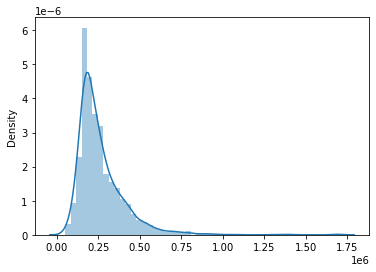

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [17]:
# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

#### Using Visualizations: lmplot
Creating linear model plots helps us visualize if variables have relationships with the dependent variable. If they do they are good candidates to include in our analysis. If they don't it doesn't mean that we should throw them out, it means we may have to process or wrangle them before they can be used.

* Using the loaded data set df filter it down to the columns `'SALESCLOSEPRICE'` and `'LIVINGAREA'` with `select()`.
* Sample 50% of the dataframe with `sample()` making sure to not use replacement and setting the random seed to 42.
* Convert the Spark DataFrame to a `pandas.DataFrame()` with `toPandas()`.
* Using `'SALESCLOSEPRICE'` as your dependent variable and `'LIVINGAREA'` as your independent, plot a linear model plot using seaborn `lmplot()`.

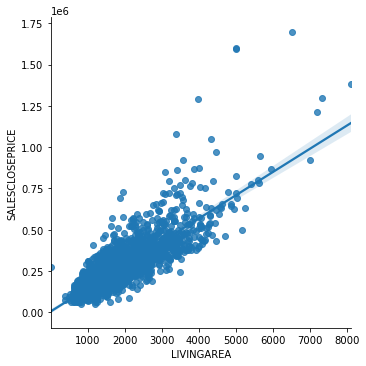

In [18]:
# Select a the relevant columns and sample
sample_df = df.select(['SALESCLOSEPRICE', 'LIVINGAREA']).sample(False, 0.5, 42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='LIVINGAREA', y='SALESCLOSEPRICE', data=pandas_df)
plt.show()

# Wrangling with Spark Functions

## Dropping data


### Dropping a list of columns
Our data set is rich with a lot of features, but not all are valuable. We have many that are going to be hard to wrangle into anything useful. For now, let's remove any columns that aren't immediately useful by dropping them.

* `'STREETNUMBERNUMERIC'`: The postal address number on the home
* `'FIREPLACES'`: Number of Fireplaces in the home
* `'LOTSIZEDIMENSIONS'`: Free text describing the lot shape
* `'LISTTYPE'`: Set list of values of sale type
* `'ACRES'`: Numeric area of lot size

Read the list of column descriptions above and explore their top 30 values with `show()`

In [19]:
# Show top 30 records
df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 'LISTTYPE', 'ACRES').show(30)

+-------------------+----------+---------------+------------------+
|STREETNUMBERNUMERIC|FIREPLACES|       LISTTYPE|             ACRES|
+-------------------+----------+---------------+------------------+
|              11511|         0|Exclusive Right|              1.28|
|              11200|         0|Exclusive Right|              0.32|
|               8583|         0|Exclusive Right|0.8220000000000001|
|               9350|         1|Exclusive Right|              0.94|
|               2915|         1|Exclusive Right|               0.0|
|               3604|         1|Exclusive Right|             0.172|
|               9957|         0|Exclusive Right|              0.05|
|               9934|         0|Exclusive Right|              0.05|
|               9926|         0|Exclusive Right|              0.05|
|               9928|         0|Exclusive Right|              0.05|
|               9902|         0|Exclusive Right|              0.05|
|               9904|         0|Exclusive Right|

Create a list of columns to drop based on their lack of relevance to predicting house prices called cols_to_drop

In [20]:
# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC']

In [21]:
# Drop columns in list
df = df.drop(*cols_to_drop)

### Using text filters to remove records
It pays to have to ask your clients lots of questions and take time to understand your variables. You find out that Assumable mortgage is an unusual occurrence in the real estate industry and your client suggests you exclude them. In this exercise we will use `isin()` which is similar to `like()` but allows us to pass a list of values to use as a filter rather than a single one.

* Use `select()` and `show()` to inspect the distinct values in the column `'ASSUMABLEMORTGAGE'` and create the list yes_values for all the values containing the string 'Yes'.

In [ ]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

In [ ]:
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

In [ ]:
# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

In [ ]:
# Print count of remaining records
print(df.count())

### Filtering numeric fields conditionally
Again, understanding the context of your data is extremely important. We want to understand what a normal range of houses sell for. Let's make sure we exclude any outlier homes that have sold for significantly more or less than the average. Here we will calculate the mean and standard deviation and use them to filer the near normal field `log_SalesClosePrice`.

In [22]:
df.select('SALESCLOSEPRICE').show()

+---------------+
|SALESCLOSEPRICE|
+---------------+
|         143000|
|         190000|
|         225000|
|         265000|
|         249900|
|         255000|
|         248000|
|         245000|
|         254990|
|         250000|
|         254500|
|         253000|
|         257500|
|         272990|
|         290000|
|         274000|
|         274990|
|         274000|
|         282000|
|         280617|
+---------------+
only showing top 20 rows



In [23]:
from pyspark.sql.functions import log
df = df.withColumn('LOG_SALESCLOSEPRICE', log('SALESCLOSEPRICE'))

In [24]:
df.select('LOG_SALESCLOSEPRICE').show()

+-------------------+
|LOG_SALESCLOSEPRICE|
+-------------------+
| 11.870599909242044|
| 12.154779351142624|
| 12.323855681186558|
| 12.487485104968359|
| 12.428816116823043|
| 12.449018824140563|
| 12.421184025147118|
| 12.409013489526863|
| 12.448979607685333|
| 12.429216196844383|
| 12.447056114972714|
| 12.441144767709657|
| 12.458774999085929|
|  12.51719044345957|
| 12.577636201962656|
| 12.520883385370206|
|  12.52449001235117|
| 12.520883385370206|
|  12.54966234992025|
| 12.544746029277201|
+-------------------+
only showing top 20 rows



In [25]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'LOG_SALESCLOSEPRICE': 'mean'}).collect()[0][0]
stddev_val = df.agg({'LOG_SALESCLOSEPRICE': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['LOG_SALESCLOSEPRICE'] < hi_bound) & (df['LOG_SALESCLOSEPRICE'] > low_bound))

## Adjusting Data


* MinMax Scaling

    - does not change distribution
    - changes the range to [0, 1]

* Standardization
    - shifting and scaling data to be closer to normal distribution
 

* Log Scaling
    - for skewed data
    - closer to normal distribution

### Custom Percentage Scaling
In the slides we showed how to scale the data between 0 and 1. Sometimes you may wish to scale things differently for modeling or display purposes.

In [26]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentagescaleddays', 
                  (df['DAYSONMARKET'] - min_days) / (max_days - min_days) * 100)

# Calc max and min for new column
print(df.agg({'percentagescaleddays': 'max'}).collect())
print(df.agg({'percentagescaleddays': 'min'}).collect())

[Row(max(percentagescaleddays)=100.0)]
[Row(min(percentagescaleddays)=0.0)]


### Scaling your scalers
In the previous exercise, we minmax scaled a single variable. Suppose you have a LOT of variables to scale, you don't want hundreds of lines to code for each. Let's expand on the previous exercise and make it a function.

In [27]:
def min_max_scaler(df, cols_to_scale):
      # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                          (df[new_column_name] - min_days) / (max_days - min_days))
    return df

In [28]:
cols_to_scale = ['FIREPLACES']

In [29]:
df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
#df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

AnalysisException: 'Cannot resolve column name "scaled_FIREPLACES" among (NO., MLSID, STREETADDRESS, STREETNAME, POSTALCODE, STATEORPROVINCE, CITY, SALESCLOSEPRICE, LISTDATE, LISTPRICE, LISTTYPE, ORIGINALLISTPRICE, PRICEPERTSFT, FOUNDATIONSIZE, MAPLETTER, SCHOOLDISTRICTNUMBER, DAYSONMARKET, OFFMARKETDATE, FIREPLACES, ROOMTYPE, POTENTIALSHORTSALE, PDOM, GARAGEDESCRIPTION, SQFTABOVEGROUND, TAXES, TAXWITHASSESSMENTS, TAXYEAR, LIVINGAREA, YEARBUILT, ZONING, STYLE, ACRES, COOLINGDESCRIPTION, BACKONMARKETDATE, EXTERIOR, BASEMENT, BATHSFULL, BATHSHALF, BATHQUARTER, BATHSTHREEQUARTER, CLASS, BATHSTOTAL, BEDROOMS, SQFTBELOWGROUND, ASSOCIATIONFEE, ASSESSMENTPENDING, ASSESSEDVALUATION, LOG_SALESCLOSEPRICE, percentagescaleddays);'

In [ ]:
df.columns

### Correcting Right Skew Data
In the slides we showed how you might use log transforms to fix positively skewed data (data whose distribution is mostly to the left). To correct negative skew (data mostly to the right) you need to take an extra step called "reflecting" before you can apply the inverse of `log`, written as `(1/log)` to make the data look more like normal a normal distribution. Reflecting data uses the following formula to reflect each value: `(x_max+1)-x`.

In [30]:
from pyspark.sql.functions import log

In [31]:
# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

[Row(skewness(YEARBUILT)=-0.24797344910486546)]


In [32]:
# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

## Working with Missing Data

### Types of Missing 
* Missing completely at random 

Missing Data is just a completely random subset 
* Missing at random 

Missing conditionally at random based on another observation 
* Missing not at random 

Data is missing because of how it is collected


### Plotting Missing Values


<AxesSubplot:>

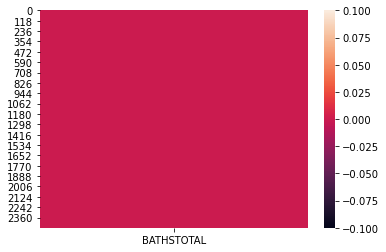

In [33]:
# Import libraryimport seaborn as sns
# subset the dataframe
sub_df = df.select(['BATHSTOTAL'])

# sample the dataframe
sample_df = sub_df.sample(False, .5, 4)

# Convert to Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.heatmap(data=pandas_df.isnull())

### Visualizing Missing Data
Being able to plot missing values is a great way to quickly understand how much of your data is missing. It can also help highlight when variables are missing in a pattern something that will need to be handled with care lest your model be biased.

Which variable has the most missing values? Run all lines of code except the last one to determine the answer. Once you're confident, and fill out the value and hit "Submit Answer".

In [34]:
columns = [
 'COOLINGDESCRIPTION',
 'BACKONMARKETDATE',
 'EXTERIOR',
 'BASEMENT',
 'CLASS',
 'BATHSTOTAL',
 'BEDROOMS'
 ]

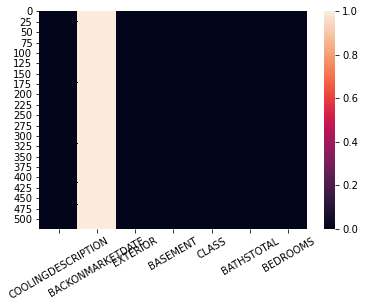

In [35]:
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [36]:
# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

### Imputing Missing Data
Missing data happens. If we make the assumption that our data is missing completely at random, we are making the assumption that what data we do have, is a good representation of the population. If we have a few values we could remove them or we could use the mean or median as a replacement. In this exercise, we will look at `'PDOM'`: Days on Market at Current Price.

In [37]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])

DataFrame[NO.: bigint, MLSID: string, STREETADDRESS: string, STREETNAME: string, POSTALCODE: bigint, STATEORPROVINCE: string, CITY: string, SALESCLOSEPRICE: bigint, LISTDATE: string, LISTPRICE: bigint, LISTTYPE: string, ORIGINALLISTPRICE: bigint, PRICEPERTSFT: double, FOUNDATIONSIZE: bigint, MAPLETTER: string, SCHOOLDISTRICTNUMBER: string, DAYSONMARKET: bigint, OFFMARKETDATE: string, FIREPLACES: bigint, ROOMTYPE: string, POTENTIALSHORTSALE: string, PDOM: bigint, GARAGEDESCRIPTION: string, SQFTABOVEGROUND: bigint, TAXES: bigint, TAXWITHASSESSMENTS: double, TAXYEAR: bigint, LIVINGAREA: bigint, YEARBUILT: bigint, ZONING: string, STYLE: string, ACRES: double, COOLINGDESCRIPTION: string, BACKONMARKETDATE: double, EXTERIOR: string, BASEMENT: string, BATHSFULL: bigint, BATHSHALF: bigint, BATHQUARTER: bigint, BATHSTHREEQUARTER: double, CLASS: string, BATHSTOTAL: bigint, BEDROOMS: bigint, SQFTBELOWGROUND: bigint, ASSOCIATIONFEE: bigint, ASSESSMENTPENDING: string, ASSESSEDVALUATION: double, LOG_

### Calculate Missing Percents
Automation is the future of data science. Learning to automate some of your data preparation pays dividends. In this exercise, we will automate dropping columns if they are missing data beyond a specific threshold.

In [38]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [ ]:
# Drop columns that are more than 60% missing
df = column_dropper(df, .6)

## Getting More Data

* PySpark Data Frame Joins


In [ ]:
DataFrame.join(other,      # Other DataFrame to merge    
               on=None,    # The keys to join on    
               how=None)   # Type of join to perform (default is 'inner')

In [ ]:
# Specify join conditoncon
d = [df['OFFMARKETDATE'] == hdf['dt']]

# Join two hdf onto df
df = df.join(hdf, on=cond, 'left')

# How many sales occurred on bank holidays?
df.where(~df['nm'].isNull()).count()

* SparkSQL Join

In [ ]:
# Register the dataframe as a temp table
df.createOrReplaceTempView("df")
hdf.createOrReplaceTempView("hdf")

In [ ]:
# Write a SQL Statement
sql_df = spark.sql("""
                    SELECT
                    *                      
                    FROM df                      
                    LEFT JOIN hdf                      
                    ON df.OFFMARKETDATE = hdf.dt
                    """)

### A Dangerous Join
In this exercise, we will be joining on Latitude and Longitude to bring in another dataset that measures how walk-friendly a neighborhood is. We'll need to be careful to make sure our joining columns are the same data type and ensure we are joining on the same precision (number of digits after the decimal) or our join won't work!

Below you will find that `df['latitude']` and `df['longitude']` are at a higher precision than `walk_df['longitude']` and `walk_df['latitude']` we'll need to round them to the same precision so the join will work correctly.

In [ ]:
# Cast data types
walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))
walk_df = walk_df.withColumn('latitude', walk_df['latitude'].cast('double'))

# Round precision
df = df.withColumn('longitude', round('longitude', 5))
df = df.withColumn('latitude', round('latitude', 5))

# Create join condition
condition = [walk_df['latitude'] == df['latitude'], walk_df['longitude'] == df['longitude']]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')

# Count non-null records from new field
print(join_df.where(~join_df['walkscore'].isNull()).count())

### Spark SQL Join
Sometimes it is much easier to write complex joins in SQL. In this exercise, we will start with the join keys already in the same format and precision but will use SparkSQL to do the joining.

In [ ]:
# Register dataframes as tables
df.createOrReplaceTempView("df")
walk_df.createOrReplaceTempView("walk_df")

# SQL to join dataframes
join_sql = """
            SELECT 
            *
            FROM df
            LEFT JOIN walk_df
            ON df.longitude = walk_df.longitude
            AND df.latitude = walk_df.latitude
            """
# Perform sql join
joined_df = spark.sql(join_sql)

### Checking for Bad Joins
Joins can go bad silently if we are not careful, meaning they will not error out but instead return mangled data with more or less data than you'd intended. Let's take a look at a couple ways that joining incorrectly can change your data set for the worse.

In this example we will look at what happens if you join two dataframes together when the join keys are not the same precision and compare the record counts between the correct join and the incorrect one.

In [ ]:
# Join on mismatched keys precision 
wrong_prec_cond = [df_orig['longitude'] == walk_df['longitude'], df_orig['latitude'] == walk_df['latitude']]
wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')

# Compare bad join to the correct one
print(wrong_prec_df.where(wrong_prec_df['walkscore'].isNull()).count())
print(correct_join_df.where(correct_join_df['walkscore'].isNull()).count())

# Create a join on too few keys
few_keys_cond = [df['longitude'] == walk_df['longitude']]
few_keys_df = df.join(walk_df, on=few_keys_cond, how='left')

# Compare bad join to the correct one
print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))
print("Record Count of the Correct Join Example: " + str(correct_join_df.count()))